<a href="https://colab.research.google.com/github/absbin/ColorHistogram/blob/master/Copy_of_Deep_Features_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
from tqdm import tqdm

import os
import sys
import cv2
import glob
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn import svm
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import zipfile

use_gpu = torch.cuda.is_available()

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
!ls "/content/drive/My Drive"

 811-800-822.pdf	       model
 classifierCATvsDOG.pt	      'Sample upload (1).txt'
 code			      'Sample upload.txt'
'Colab Notebooks'	       sesssion1_DL_cnn_pytorch.ipynb
'Copy of Untitled1.ipynb'     'Translated copy of 811-800-822.pdf.gdoc'
 data			       Untitled1.ipynb
 foo.txt		       week1snrDL
'kargah DL with python code'  'پروپزال دوستان'
 laparoscopy


In [0]:
local_zip = '/content/drive/My Drive/data/WCE_dataset_3.zip'



In [0]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/data')
zip_ref.close()



In [0]:
#base_dir = '/content/drive/My Drive/data/WCE_dataset_3'
trn_dir = '/data/WCE_dataset_3'


In [0]:
classes=os.listdir(trn_dir)

In [64]:
classes

['informative', 'ambiguous', 'noninformative']

In [10]:
classes[0]

'informative'

In [11]:
trn_frames = glob.glob(f'{trn_dir}/*/*.jpg')

len(trn_frames)


1586

In [0]:
trn_frames = glob.glob(f'{trn_dir}/informative/*.jpg')

In [14]:
!ls

drive  image.png  sample_data


In [15]:
print( os.getcwd() )

/content


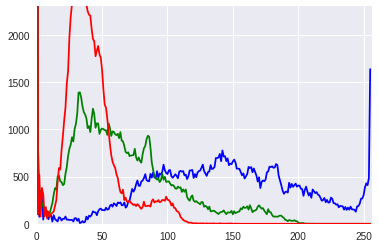

In [16]:
show_color_histogram(plt.imread(trn_frames[305]))


In [0]:
from google.colab import files
 

In [0]:
trn_frames2=(glob.glob(f'{trn_dir}/noninformative/*.jpg'))

In [0]:
trn_frames.extend(trn_frames2)

In [20]:
len(trn_frames)

1352

In [21]:
frames_informative = glob.glob(f'{trn_dir}/informative/*.jpg')
len(trn_frames)

1352

**Model**

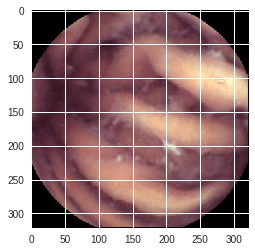

In [65]:
img=plt.imread(trn_frames[155])
plt.imshow(img)

In [0]:
import  skimage
from skimage import color
from skimage import data
import matplotlib.pyplot as plt



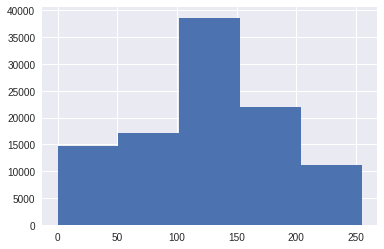

In [25]:
bin_counts,_,_  = plt.hist(img[:,:,0].ravel(), bins=5)


In [0]:
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
def feature_extractor(X):

    trn_dir=X
    #model_vgg16 = VGG16(weights='imagenet', include_top=False)
    model_vgg16 = ResNet50(weights='imagenet', include_top=False)
    vgg16_feature_list = []
    vgg16_feature_list_np=[]
    labels_true=[]
    hsv=[]
    img_address=[]
    for idx, dirname in enumerate(os.listdir(trn_dir)):
        # get the directory names, i.e., 'dogs' or 'cats'
        # ...
        if dirname!='ambiguous':
            print(idx,dirname)
            class_frames=glob.glob(f'{os.path.join(trn_dir, dirname)}/*.jpg')
            for i, fname in enumerate(class_frames ):

#                 print(i,fname)
                # process the files under the directory 'dogs' or 'cats'
                # ...       
                img = image.load_img(fname, target_size=(224, 224))          


#                 input("Press Enter to continue...")
#                 img_hsv=skimage.color.rgb2hsv(img)
#                 bin_conts=plt.hist(img[:,:,0].ravel(), bins=8)
#                 hsv.extend(bin_conts[0])
#                 bin_conts=plt.hist(img[:,:,1].ravel(), bins=4)
#                 hsv.extend(bin_conts[0])
#                 bin_conts=plt.hist(img[:,:,2].ravel(), bins=4)
#                 hsv.extend(bin_conts[0])
#                 input("Press Enter to continue...")

                img_data = image.img_to_array(img)
                img_data = np.expand_dims(img_data, axis=0)
                img_data = preprocess_input(img_data)
                vgg16_feature = model_vgg16.predict(img_data)
                vgg16_feature_np = np.array(vgg16_feature)
                vgg16_feature_list.append(vgg16_feature_np.flatten())
                labels_true.append(idx)
                img_address.append(fname)
    vgg16_feature_list_np = np.array(vgg16_feature_list)
    labels_true = np.array(labels_true)
    return vgg16_feature_list_np , labels_true,img_address


In [68]:
x_data,y_data,img_address=feature_extractor(trn_dir)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


0 informative
2 noninformative


In [0]:
x_data_recovered=x_data


In [0]:
# from color_histogram.io_util.image import loadRGB
# from color_histogram.core.hist_1d import Hist1D
from keras.preprocessing import image

def hsv_feature_extractor(X):
    trn_dir=X
    labels_true=[]    
    hsv_vec=[]
    for idx, dirname in enumerate(os.listdir(trn_dir)):
        if dirname!='ambiguous':
            print(idx,dirname)
            class_frames=glob.glob(f'{os.path.join(trn_dir, dirname)}/*.jpg')
            for i, fname in enumerate(class_frames ):
                img_original = image.load_img(fname) 
                print(i,fname)

                img_hsv=skimage.color.rgb2hsv(img_original)
                f=[]
                hsv=[]
                bin=[]
                h=img_hsv[:,:,0].ravel()
                s=img_hsv[:,:,1].ravel()
                v=img_hsv[:,:,2].ravel()
                bin,_,_=plt.hist(h, bins=8)
                hsv.extend(bin)
                bin,_,_=plt.hist(s, bins=4)
                hsv.extend(bin)
                bin,_,_=plt.hist(s, bins=4)
                hsv.extend(bin)
                plt.clf()
#                 print(hsv)
                f=[h.mean(),h.std(),s.mean(),s.std(), v.mean(),v.std()]
                f.extend(hsv)
                print(f)
#                 print(img_hsv[100:200,100:200,1])
#                 plt.imshow(img_hsv)
#                 input("Press Enter to continue...")               
                hsv_vec.append(f)  
                labels_true.append(idx)
    hsv_vec=np.array(hsv_vec)
    labels_true = np.array(labels_true)
    return hsv_vec,labels_true

In [0]:
x_data_hsv,y_data=hsv_feature_extractor(trn_dir)


In [0]:
x_data=x_data_hsv

In [111]:
# x_data,y_data,hsv_vec=feature_extractor(trn_dir)
x_data2= np.hstack([x_data,x_data_hsv])
x_data=x_data2
(x_data.shape,y_data.shape,x_data_hsv.shape,x_data2.shape)


((1352, 44), (1352,), (1352, 22), (1352, 44))

In [0]:
x_data=x_data_recovered

In [0]:
x_train, x_test, y_train, y_test ,img_address_train,img_address_test= train_test_split(x_data, y_data,img_address, test_size=0.20, random_state=4)

In [70]:
(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

((1081, 100352), (1081,), (271, 100352), (271,))

In [115]:
(np.sort(x_train[19]),np.sort(x_test[90]))

(array([ 0.      ,  0.      ,  0.      , ..., 34.358494, 38.50371 ,
        40.94607 ], dtype=float32),
 array([ 0.      ,  0.      ,  0.      , ..., 30.432352, 37.117107,
        39.87756 ], dtype=float32))

**PCA performs best with a normalized feature set. We will perform standard scalar normalization to normalize our feature set**

---



In [190]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(x_train)

# Apply transform to both the training set and the test set.
train_img = scaler.transform(x_train)
test_img = scaler.transform(x_test)
(train_img.shape,y_train.shape,test_img.shape,y_test.shape)

((1081, 100352), (1081,), (271, 100352), (271,))

In [0]:
x_train=train_img
x_test=test_img

**Performing PCA for dimentionality reduction**


> 

---




> 



In [0]:
pca=PCA()
# pca = PCA(.05)  
x_train = pca.fit_transform(train_img)  
x_test = pca.transform(test_img)

print(train_img.shape,test_img.shape)
print(x_train.shape,x_test.shape)

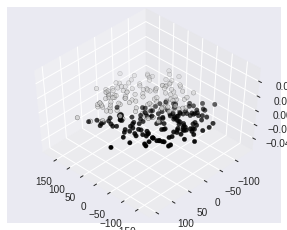

In [82]:
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(x_test)
X = pca.transform(x_test)

# for name, label in [('Setosa', 0), ('Versicolour', 2)]:
#     ax.text3D(X[y_test == label, 0].mean(),
#               X[y_test == label, 2].mean() + 1.5,
#               name,
#               horizontalalignment='center',
#               bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y_test = np.choose(y_test, [ 2,1, 0]).astype(np.float)
ax.scatter(X[:, 0],  X[:, 2], c=y_test, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

In [0]:
#x_train= np.hstack([x_train,train_img])
#x_test= np.hstack([x_test,test_img])

# **CLASSIFIER 

---




**SVM**

In [52]:
clf = svm.SVC(gamma='scale')
clf.fit(x_train, y_train)  


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
score=clf.score(x_test, y_test, sample_weight=None)
"%.4f" %score

'0.8679'

In [54]:
y_test_pred=clf.predict(x_test)
print(confusion_matrix(y_test,y_test_pred))

[[113   1   1]
 [ 12  14  20]
 [  6   2 149]]


/data/WCE_dataset_3/noninformative/alireza alipor 2017_03_01 ( 00.24.12 )_croped.jpg has been classified as  ambiguous and should be  noninformative
/data/WCE_dataset_3/ambiguous/hidsr gholi kesharo 2 2017_11_12 ( 00.41.24 )_1_croped.jpg has been classified as  noninformative and should be  ambiguous
/data/WCE_dataset_3/ambiguous/farman mohamadiyan 2018_05_06 ( 00.29.02 )_croped.jpg has been classified as  noninformative and should be  ambiguous
/data/WCE_dataset_3/ambiguous/ali mir damad 2017_09_18 ( 09.12.54 )_croped.jpg has been classified as  informative and should be  ambiguous
/data/WCE_dataset_3/ambiguous/abdolah yadegari 2017_11_05 ( 05.28.25 )_croped.jpg has been classified as  informative and should be  ambiguous
/data/WCE_dataset_3/ambiguous/farman mohamadiyan 2018_05_06 ( 00.39.13 )_croped.jpg has been classified as  noninformative and should be  ambiguous
/data/WCE_dataset_3/ambiguous/farman mohamadiyan 2018_05_06 ( 07.01.55 )_croped.jpg has been classified as  noninformat

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/data/WCE_dataset_3/noninformative/azizo alah nemATI 2017_02_05 ( 05.09.01 )_croped.jpg has been classified as  informative and should be  noninformative
/data/WCE_dataset_3/ambiguous/ali mir damad 2017_09_18 ( 09.09.46 )_croped.jpg has been classified as  noninformative and should be  ambiguous
/data/WCE_dataset_3/ambiguous/hidsr gholi kesharo 2 2017_11_12 ( 02.29.30 )_croped.jpg has been classified as  noninformative and should be  ambiguous
/data/WCE_dataset_3/ambiguous/ali mir damad 2017_09_18 ( 09.22.09 )_croped.jpg has been classified as  noninformative and should be  ambiguous
/data/WCE_dataset_3/noninformative/farman mohamadiyan 2018_05_06 ( 00.28.29 )_1_croped.jpg has been classified as  ambiguous and should be  noninformative
/data/WCE_dataset_3/noninformative/azizo alah nemATI 2017_02_05 ( 06.05.38 )_croped.jpg has been classified as  informative and should be  noninformative
/data/WCE_dataset_3/informative/azam zand 2017_05_19 ( 03.05.05 )_croped.jpg has been classified as 

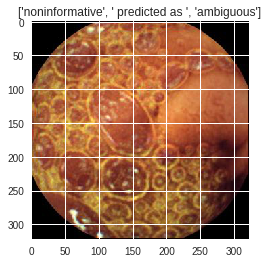

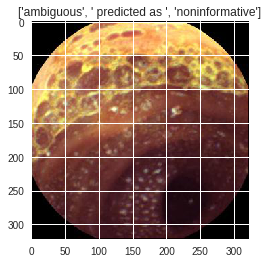

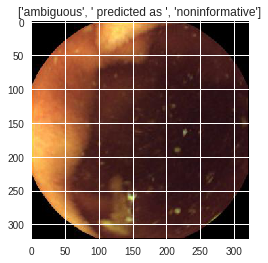

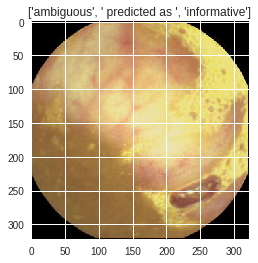

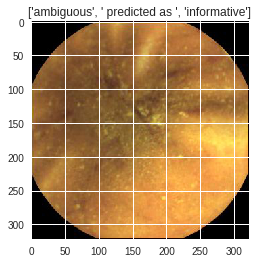

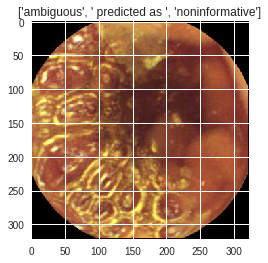

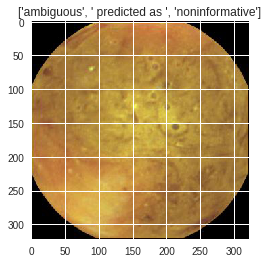

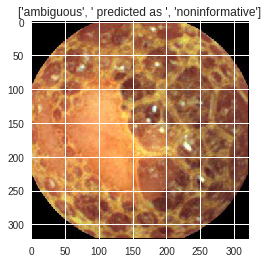

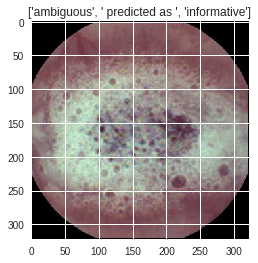

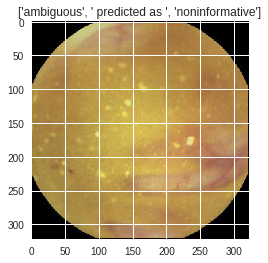

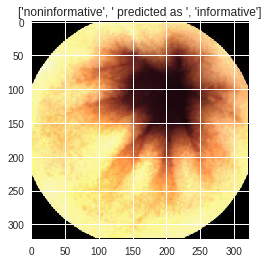

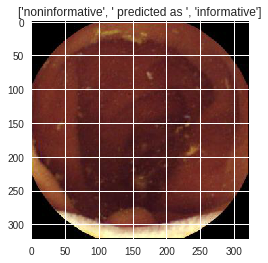

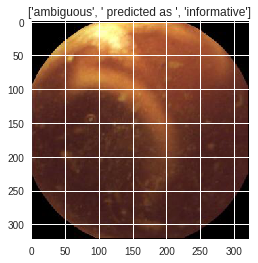

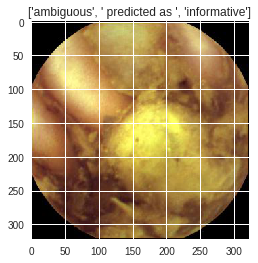

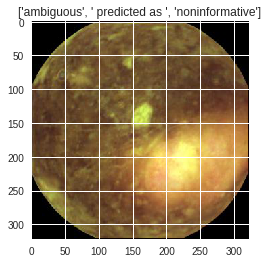

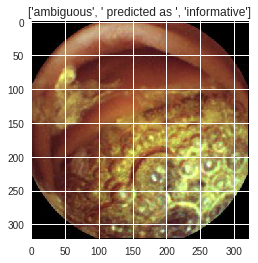

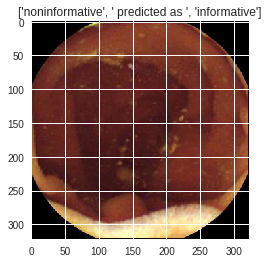

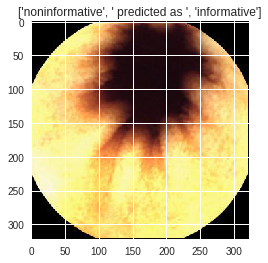

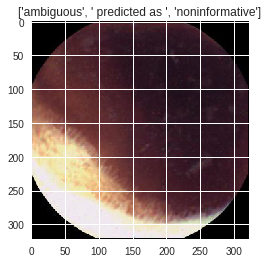

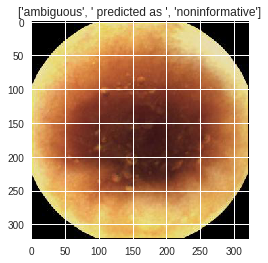

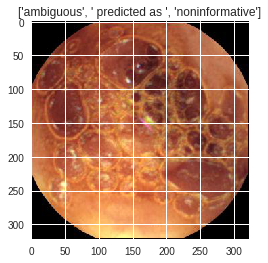

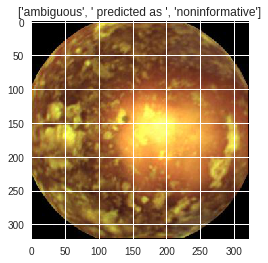

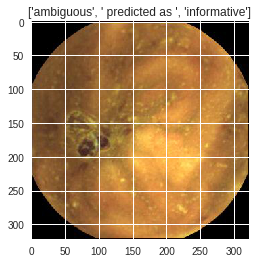

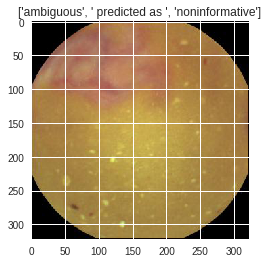

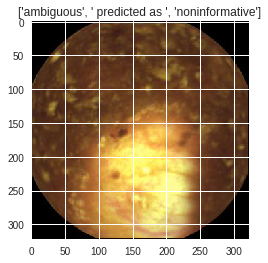

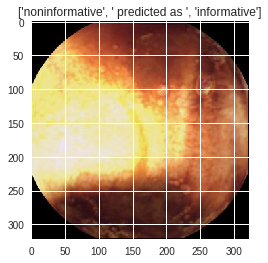

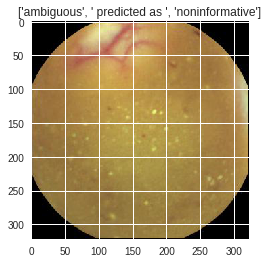

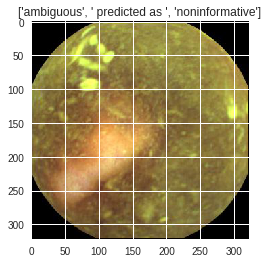

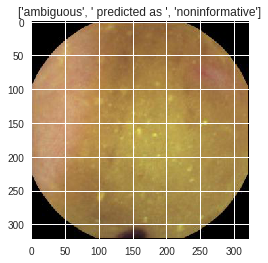

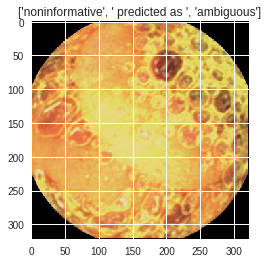

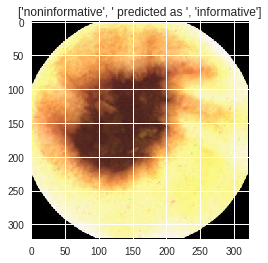

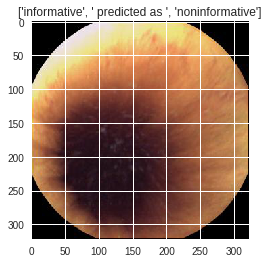

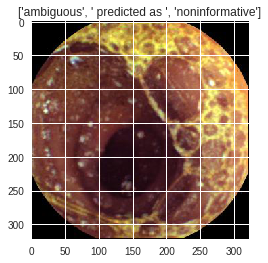

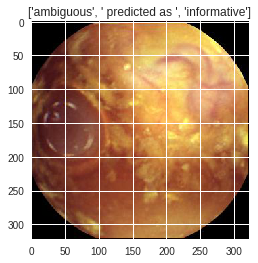

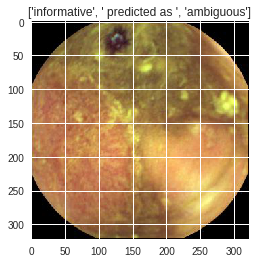

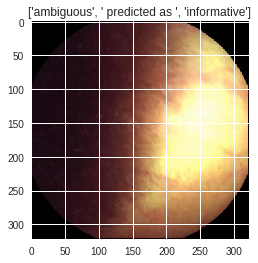

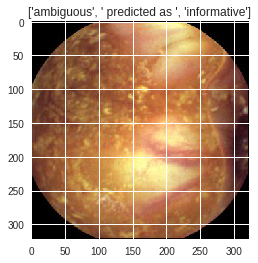

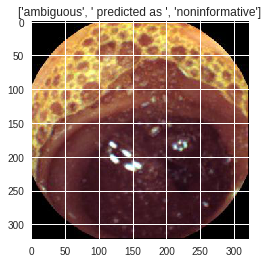

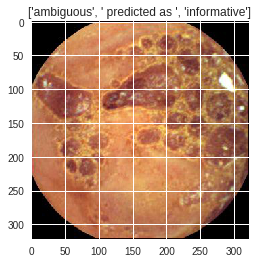

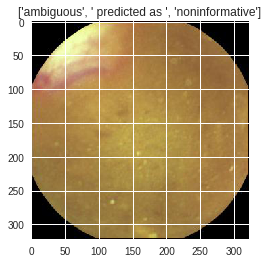

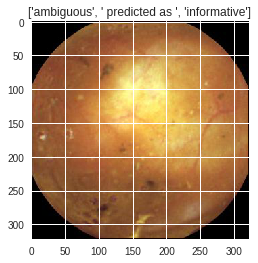

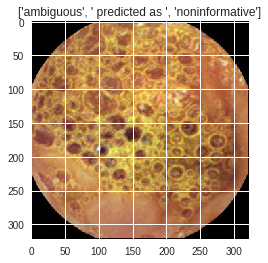

In [55]:
for input, prediction, label in zip(img_address_test, y_test_pred, y_test):
  if prediction != label:
    plt.figure()
    plt.title([classes[label]," predicted as "  , classes[prediction]])
    plt.imshow(plt.imread(input))
    print(input, 'has been classified as ', classes[prediction], 'and should be ', classes[label]) 

In [0]:
# =================== Using 4 Fold Cross Validation to check the consistency of the final model ====================
model=clf
sk_fold = StratifiedKFold(n_splits=4, shuffle=True)
for train_index, test_index in sk_fold.split(x_data, y_data):
    x_train_c, x_test_c = x_data[train_index], x_data[test_index]
    y_train_c, y_test_c = y_data[train_index], y_data[test_index]
    

    # predictions for train
    print("TRAIN:", train_index, "TEST:", test_index)
    model.fit(x_train_c, y_train_c)
    y_pred_train = model.predict(x_train_c)
    # predictions for test
    y_pred_test = model.predict(x_test_c)
    # training metrics
    print("Training metrics:")
    print(metrics.classification_report(y_true= y_train_c, y_pred= y_pred_train))
    
    # test data metrics
    print("Test data metrics:")
    print(metrics.classification_report(y_true= y_test_c, y_pred= y_pred_test))
    


# SVM gready search hyper parameter tuninig

In [0]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=4)

In [0]:

def svc_param_selection(X, y, nfolds):
    Cs = [0.001 ,0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_


In [0]:
model_param=svc_param_selection(x_valid,y_valid,3)

In [0]:
model_param

## ***Random Forest***

In [139]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
X =x_train
Y = y_train
clf_rf = RandomForestClassifier(n_estimators=10)
clf = clf_rf.fit(X, Y)
scores = cross_val_score(clf, x_test, y_test, cv=5)
scores.mean() 


0.8857061177815894

In [0]:
y_valid_pred=clf.predict(x_valid)
print(confusion_matrix(y_valid,y_valid_pred))

In [0]:
clf = GridSearchCV(clf_rf, param_grid={'n_estimators':[100,200],'min_samples_leaf':[2,3]})
model = clf.fit(x_train,y_train)

In [0]:
scores = cross_val_score(clf, x_test, y_test, cv=5)
scores.mean() 

In [0]:
y_test_pred=clf.predict(x_test)
print(confusion_matrix(y_test,y_test_pred))

In [0]:
!git clone https://github.com/zeyiwen/thundersvm.git

In [0]:
!ls

In [0]:
!ls thundersvm

In [0]:
os.chdir ("thundersvm")

In [0]:
os.chdir ("python")

In [0]:
!ls

In [0]:
!python setup.py install

In [0]:
!ls

In [0]:
!mkdir build
!cd build
!cmake ..  -DCMAKE_WINDOWS_EXPORT_ALL_SYMBOLS=TRUE -DBUILD_SHARED_LIBS=TRUE -G "Visual Studio 14 2015 Win64"

In [0]:
!cmake --version

In [0]:
!pip install --upgrade cmake

In [0]:
from svm import *
y,x = svm_read_problem('../dataset/test_dataset.txt')
svm_train(y,x,'test_dataset.txt.model','-c 100 -g 0.5')
y,x=svm_read_problem('../dataset/test_dataset.txt')
svm_predict(y,x,'test_dataset.txt.model','test_dataset.predict')